In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from model_file import *
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, getNaryDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

In [2]:
model = getModel("resnet50")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


Order of classes:
* Normal
* Erosion
* Polyp
* Angioectasia
* Bleeding
* Lymphangiectasia
* Foreign Body
* Erythema
* Ulcer
* Worms

In [3]:
train_path = "/kaggle/input/vce-dataset/training"
val_path = "/kaggle/input/vce-dataset/validation"

In [4]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.7),
                                     transforms.RandomVerticalFlip(p=0.7),
                                     transforms.RandomRotation(15),
                                     
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor()
                              ])


val_transform= transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

In [5]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

# Binary

In [6]:
target_class_names = ["Normal"]
binDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
binDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [7]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [9]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
model = model.to(device)

In [11]:
num_epochs = 2

In [12]:
%%time
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in binDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if(i%100 == 0):
            print(f"Bin - [{i}/{len(binDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in binDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Bin - [0/1176] train loss : 0.7909814119338989
Bin - [100/1176] train loss : 0.3893841803073883
Bin - [200/1176] train loss : 0.4344397187232971
Bin - [300/1176] train loss : 0.8760740756988525
Bin - [400/1176] train loss : 0.42592281103134155
Bin - [500/1176] train loss : 0.2807391881942749
Bin - [600/1176] train loss : 0.29987940192222595
Bin - [700/1176] train loss : 0.3599053621292114
Bin - [800/1176] train loss : 0.49088814854621887
Bin - [900/1176] train loss : 0.5329098701477051
Bin - [1000/1176] train loss : 0.3676598072052002
Bin - [1100/1176] train loss : 0.5372167229652405
Epoch [1/2]
Train Loss: 0.3771, Train Accuracy: 0.8235
Validation Loss: 0.5622, Validation Accuracy: 0.7968
Bin - [0/1176] train loss : 0.6569541692733765
Bin - [100/1176] train loss : 0.14759650826454163
Bin - [200/1176] train loss : 0.35575738549232483
Bin - [300/1176] train loss : 0.637710452079773
Bin - [400/1176] train loss : 0.33661043643951416
Bin - [500/1176] train loss : 0.3464619219303131
Bin - [

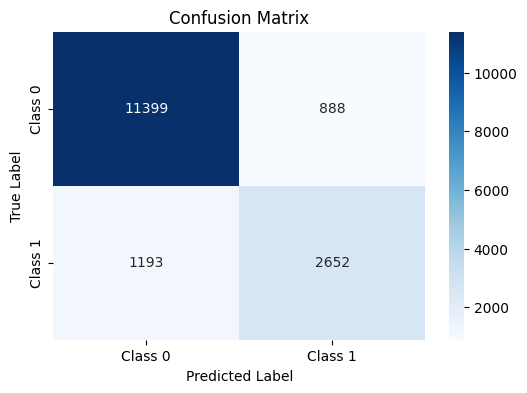

In [13]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, binDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
del binDL_train
del binDL_val

# Ternary

In [15]:
target_class_names = ["Normal","Erosion"]
terDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
terDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [16]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
model = model.to(device)

In [20]:
num_epochs = 3

In [21]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in terDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Ter - [{i}/{len(terDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in terDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Ter - [0/1176] train loss : 1.0790942907333374
Ter - [100/1176] train loss : 0.4427805542945862
Ter - [200/1176] train loss : 0.34946101903915405
Ter - [300/1176] train loss : 0.30240219831466675
Ter - [400/1176] train loss : 0.41724491119384766
Ter - [500/1176] train loss : 0.3796144127845764
Ter - [600/1176] train loss : 0.45484474301338196
Ter - [700/1176] train loss : 0.36544445157051086
Ter - [800/1176] train loss : 0.4151952862739563
Ter - [900/1176] train loss : 0.34117332100868225
Ter - [1000/1176] train loss : 0.31150323152542114
Ter - [1100/1176] train loss : 0.654608964920044
Epoch [1/3]
Train Loss: 0.4044, Train Accuracy: 0.8235
Validation Loss: 0.4966, Validation Accuracy: 0.7993
Ter - [0/1176] train loss : 0.6071217060089111
Ter - [100/1176] train loss : 0.4205366373062134
Ter - [200/1176] train loss : 0.4907703697681427
Ter - [300/1176] train loss : 0.4940725564956665
Ter - [400/1176] train loss : 0.3297749161720276
Ter - [500/1176] train loss : 0.29597368836402893
Ter -

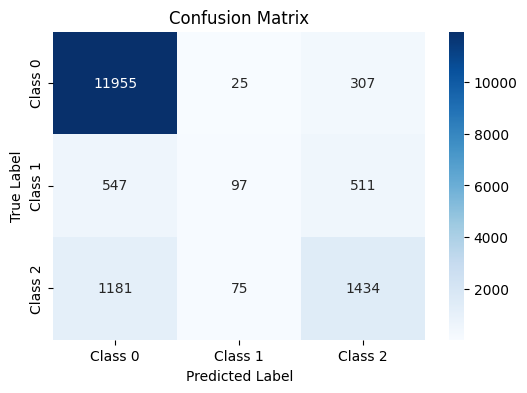

In [22]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, terDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
del terDL_train
del terDL_val

# Quaternary

In [24]:
target_class_names = ["Normal","Erosion","Polyp"]
quatDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
quatDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [25]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [27]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
model = model.to(device)

In [29]:
num_epochs = 4

In [30]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in quatDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Quat - [{i}/{len(quatDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in quatDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Quat - [0/1176] train loss : 1.412927269935608
Quat - [100/1176] train loss : 0.49938783049583435
Quat - [200/1176] train loss : 0.19171935319900513
Quat - [300/1176] train loss : 0.5116538405418396
Quat - [400/1176] train loss : 0.29181620478630066
Quat - [500/1176] train loss : 0.41565895080566406
Quat - [600/1176] train loss : 0.310702919960022
Quat - [700/1176] train loss : 0.6768542528152466
Quat - [800/1176] train loss : 0.4380282461643219
Quat - [900/1176] train loss : 0.27773401141166687
Quat - [1000/1176] train loss : 0.2112203985452652
Quat - [1100/1176] train loss : 0.28078600764274597
Epoch [1/4]
Train Loss: 0.3909, Train Accuracy: 0.8510
Validation Loss: 0.4273, Validation Accuracy: 0.8405
Quat - [0/1176] train loss : 0.43942394852638245
Quat - [100/1176] train loss : 0.43248775601387024
Quat - [200/1176] train loss : 0.6848973035812378
Quat - [300/1176] train loss : 0.2693712115287781
Quat - [400/1176] train loss : 0.22975076735019684
Quat - [500/1176] train loss : 0.3157

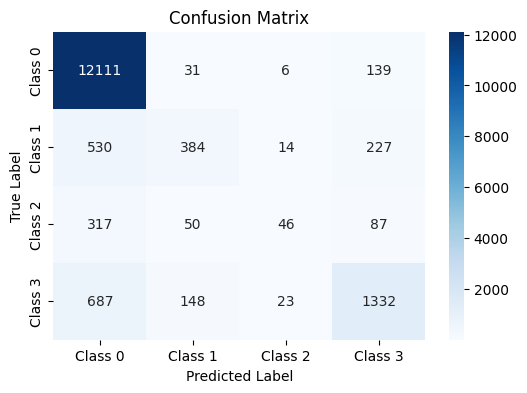

In [31]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, quatDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [32]:
del quatDL_train
del quatDL_val

# Pentanary

In [33]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia"]
pentDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
pentDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [34]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [36]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
model = model.to(device)

In [38]:
num_epochs = 5

In [39]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in pentDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Pent - [{i}/{len(pentDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in pentDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Pent - [0/1176] train loss : 2.027250289916992
Pent - [100/1176] train loss : 0.2790639102458954
Pent - [200/1176] train loss : 0.2674429714679718
Pent - [300/1176] train loss : 0.6662746667861938
Pent - [400/1176] train loss : 0.2669607400894165
Pent - [500/1176] train loss : 0.36924654245376587
Pent - [600/1176] train loss : 0.6310205459594727
Pent - [700/1176] train loss : 0.44395896792411804
Pent - [800/1176] train loss : 0.4545394480228424
Pent - [900/1176] train loss : 0.30942025780677795
Pent - [1000/1176] train loss : 0.26176849007606506
Pent - [1100/1176] train loss : 0.15801073610782623
Epoch [1/5]
Train Loss: 0.3705, Train Accuracy: 0.8655
Validation Loss: 0.4281, Validation Accuracy: 0.8496
Pent - [0/1176] train loss : 0.2966002821922302
Pent - [100/1176] train loss : 0.3386543095111847
Pent - [200/1176] train loss : 0.37210172414779663
Pent - [300/1176] train loss : 0.7380220890045166
Pent - [400/1176] train loss : 0.664692759513855
Pent - [500/1176] train loss : 0.5172102

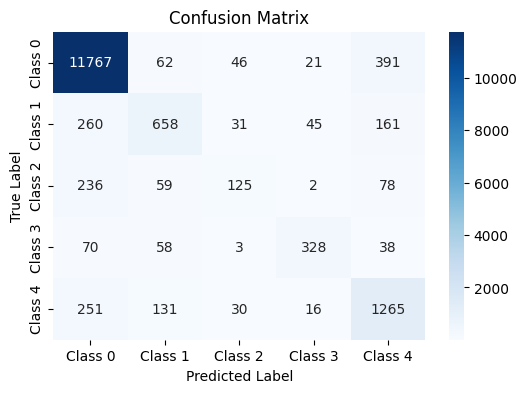

In [40]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, pentDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
del pentDL_train
del pentDL_val

# Senary

In [42]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding"]
senDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
senDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [43]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [45]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
model = model.to(device)

In [47]:
num_epochs = 6

In [48]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in senDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"[Sen - {i}/{len(senDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in senDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

[Sen - 0/1176] train loss : 1.559638500213623
[Sen - 100/1176] train loss : 0.41239720582962036
[Sen - 200/1176] train loss : 0.2147323489189148
[Sen - 300/1176] train loss : 0.13465970754623413
[Sen - 400/1176] train loss : 0.38576412200927734
[Sen - 500/1176] train loss : 0.3145352303981781
[Sen - 600/1176] train loss : 0.19937320053577423
[Sen - 700/1176] train loss : 0.2317735105752945
[Sen - 800/1176] train loss : 0.20972208678722382
[Sen - 900/1176] train loss : 0.25843101739883423
[Sen - 1000/1176] train loss : 0.27670180797576904
[Sen - 1100/1176] train loss : 0.07082508504390717
Epoch [1/6]
Train Loss: 0.3187, Train Accuracy: 0.8900
Validation Loss: 0.3967, Validation Accuracy: 0.8683
[Sen - 0/1176] train loss : 0.2512650787830353
[Sen - 100/1176] train loss : 0.2112232744693756
[Sen - 200/1176] train loss : 0.4280259311199188
[Sen - 300/1176] train loss : 0.24941641092300415
[Sen - 400/1176] train loss : 0.4052334427833557
[Sen - 500/1176] train loss : 0.3987770080566406
[Sen

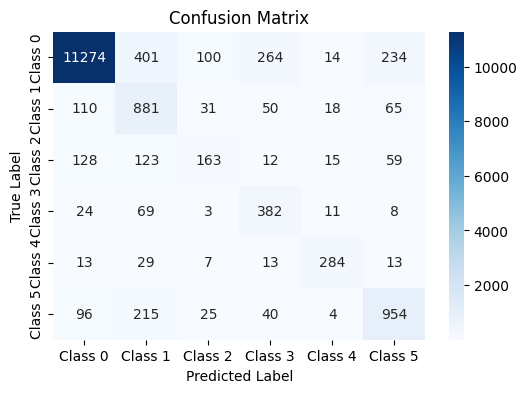

In [49]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, senDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
del senDL_train
del senDL_val

# Septenary

In [51]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia"]
septDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
septDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [52]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [54]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
model = model.to(device)

In [56]:
num_epochs = 7

In [57]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in septDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Sept - [{i}/{len(septDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in septDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Sept - [0/1176] train loss : 1.9691519737243652
Sept - [100/1176] train loss : 0.2168794870376587
Sept - [200/1176] train loss : 0.14581894874572754
Sept - [300/1176] train loss : 0.2718738615512848
Sept - [400/1176] train loss : 0.1007678434252739
Sept - [500/1176] train loss : 0.2198568731546402
Sept - [600/1176] train loss : 0.34577295184135437
Sept - [700/1176] train loss : 0.3469672203063965
Sept - [800/1176] train loss : 0.3047991096973419
Sept - [900/1176] train loss : 0.18047887086868286
Sept - [1000/1176] train loss : 0.1264537125825882
Sept - [1100/1176] train loss : 0.2504444718360901
Epoch [1/7]
Train Loss: 0.2853, Train Accuracy: 0.9032
Validation Loss: 0.4508, Validation Accuracy: 0.8587
Sept - [0/1176] train loss : 0.4806485176086426
Sept - [100/1176] train loss : 0.2534679174423218
Sept - [200/1176] train loss : 0.29300951957702637
Sept - [300/1176] train loss : 0.15654799342155457
Sept - [400/1176] train loss : 0.1388782113790512
Sept - [500/1176] train loss : 0.075247

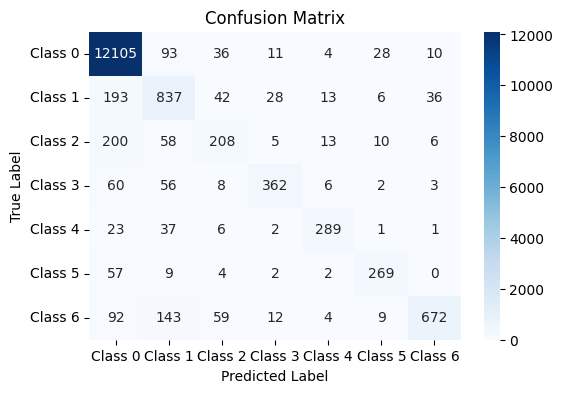

In [58]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, septDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [59]:
del septDL_train
del septDL_val

# Octal

In [60]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body"]
octDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
octDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [61]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [63]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [64]:
model = model.to(device)

In [65]:
num_epochs = 8

In [66]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in octDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Oct - [{i}/{len(octDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in octDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Oct - [0/1176] train loss : 2.198258876800537
Oct - [100/1176] train loss : 0.4691775441169739
Oct - [200/1176] train loss : 0.3059997260570526
Oct - [300/1176] train loss : 0.10485783964395523
Oct - [400/1176] train loss : 0.13020506501197815
Oct - [500/1176] train loss : 0.24221201241016388
Oct - [600/1176] train loss : 0.10793156176805496
Oct - [700/1176] train loss : 0.11503341048955917
Oct - [800/1176] train loss : 0.03787016123533249
Oct - [900/1176] train loss : 0.13947908580303192
Oct - [1000/1176] train loss : 0.21824800968170166
Oct - [1100/1176] train loss : 0.2582828998565674
Epoch [1/8]
Train Loss: 0.2570, Train Accuracy: 0.9147
Validation Loss: 0.3882, Validation Accuracy: 0.8778
Oct - [0/1176] train loss : 0.05520565062761307
Oct - [100/1176] train loss : 0.2661575973033905
Oct - [200/1176] train loss : 0.17996981739997864
Oct - [300/1176] train loss : 0.11484388262033463
Oct - [400/1176] train loss : 0.38889479637145996
Oct - [500/1176] train loss : 0.1919083595275879
O

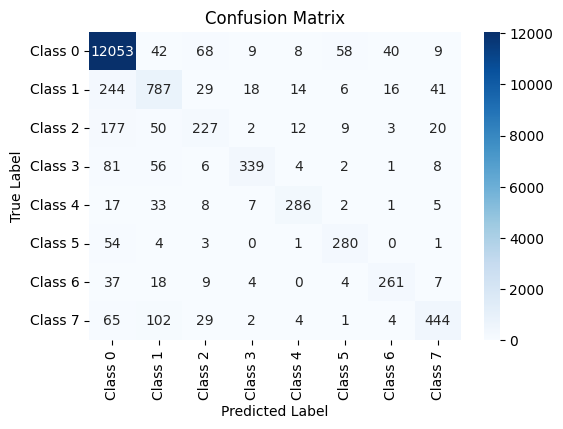

In [67]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, octDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [68]:
del octDL_train
del octDL_val

# Nonary

In [69]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema"]
nonDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
nonDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [70]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [72]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [73]:
model = model.to(device)

In [74]:
num_epochs = 9

In [75]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in nonDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Non - [{i}/{len(nonDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in nonDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Non - [0/1176] train loss : 2.5752079486846924
Non - [100/1176] train loss : 0.13530921936035156
Non - [200/1176] train loss : 0.15099197626113892
Non - [300/1176] train loss : 0.19160832464694977
Non - [400/1176] train loss : 0.14013244211673737
Non - [500/1176] train loss : 0.1715463250875473
Non - [600/1176] train loss : 0.26857587695121765
Non - [700/1176] train loss : 0.20669017732143402
Non - [800/1176] train loss : 0.08147351443767548
Non - [900/1176] train loss : 0.2292148768901825
Non - [1000/1176] train loss : 0.08332031220197678
Non - [1100/1176] train loss : 0.10538073629140854
Epoch [1/9]
Train Loss: 0.2256, Train Accuracy: 0.9250
Validation Loss: 0.2765, Validation Accuracy: 0.9070
Non - [0/1176] train loss : 0.21272118389606476
Non - [100/1176] train loss : 0.13638852536678314
Non - [200/1176] train loss : 0.05251694843173027
Non - [300/1176] train loss : 0.21748559176921844
Non - [400/1176] train loss : 0.03353322297334671
Non - [500/1176] train loss : 0.071611456573009

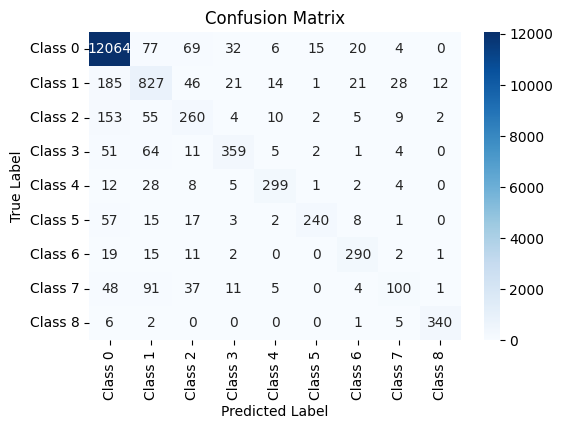

In [76]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, nonDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [77]:
del nonDL_train
del nonDL_val

# Decimal

In [78]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema","Ulcer"]
decDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
decDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [79]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [81]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [82]:
model = model.to(device)

In [83]:
num_epochs = 10

In [84]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in decDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Dec - [{i}/{len(decDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in decDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Dec - [0/1176] train loss : 2.557032585144043
Dec - [100/1176] train loss : 0.22557106614112854
Dec - [200/1176] train loss : 0.16013985872268677
Dec - [300/1176] train loss : 0.13662084937095642
Dec - [400/1176] train loss : 0.09384875744581223
Dec - [500/1176] train loss : 0.02743530459702015
Dec - [600/1176] train loss : 0.053130388259887695
Dec - [700/1176] train loss : 0.18353396654129028
Dec - [800/1176] train loss : 0.41516393423080444
Dec - [900/1176] train loss : 0.06318777799606323
Dec - [1000/1176] train loss : 0.3099803924560547
Dec - [1100/1176] train loss : 0.06213516741991043
Epoch [1/10]
Train Loss: 0.1989, Train Accuracy: 0.9345
Validation Loss: 0.2818, Validation Accuracy: 0.9084
Dec - [0/1176] train loss : 0.0806257352232933
Dec - [100/1176] train loss : 0.12578627467155457
Dec - [200/1176] train loss : 0.13876520097255707
Dec - [300/1176] train loss : 0.3810300827026367
Dec - [400/1176] train loss : 0.12062959372997284
Dec - [500/1176] train loss : 0.066887483000755

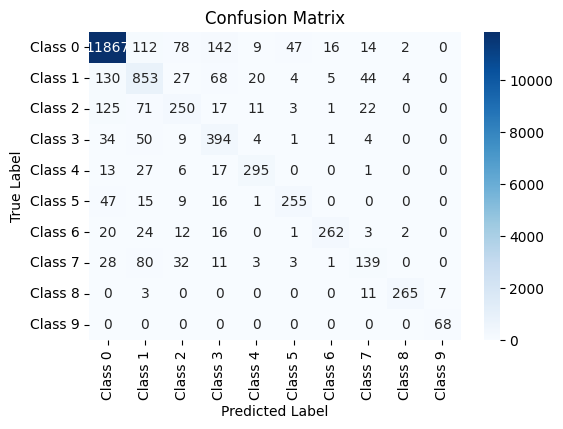

In [85]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, decDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [86]:
del decDL_train
del decDL_val

# Final

In [87]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema","Ulcer","Worms"]
finDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
finDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [88]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [90]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [91]:
model = model.to(device)

In [92]:
num_epochs = 15

In [93]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in finDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Fin - [{i}/{len(finDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in finDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Fin - [0/1176] train loss : 3.0295767784118652
Fin - [100/1176] train loss : 0.0659606009721756
Fin - [200/1176] train loss : 0.05336415395140648
Fin - [300/1176] train loss : 0.05527076870203018
Fin - [400/1176] train loss : 0.05060533061623573
Fin - [500/1176] train loss : 0.49792569875717163
Fin - [600/1176] train loss : 0.23915544152259827
Fin - [700/1176] train loss : 0.10828927159309387
Fin - [800/1176] train loss : 0.07824499905109406
Fin - [900/1176] train loss : 0.28034812211990356
Fin - [1000/1176] train loss : 0.13936571776866913
Fin - [1100/1176] train loss : 0.2507406771183014
Epoch [1/15]
Train Loss: 0.1671, Train Accuracy: 0.9455
Validation Loss: 0.2609, Validation Accuracy: 0.9164
Fin - [0/1176] train loss : 0.023567209020256996
Fin - [100/1176] train loss : 0.14125292003154755
Fin - [200/1176] train loss : 0.34424588084220886
Fin - [300/1176] train loss : 0.23879374563694
Fin - [400/1176] train loss : 0.15495721995830536
Fin - [500/1176] train loss : 0.1463023424148559

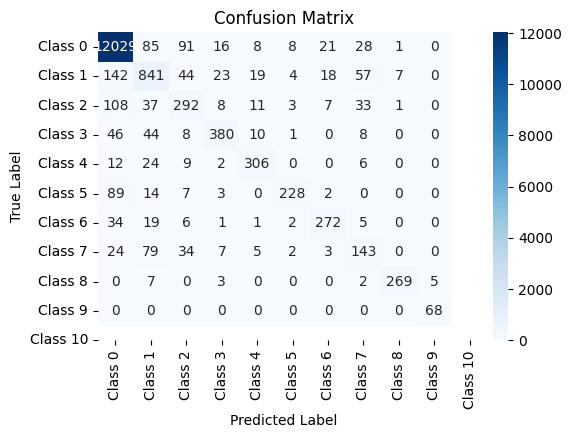

In [94]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, finDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [95]:
del finDL_train
del finDL_val

In [96]:
final_path = "checkpoint.pth"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, final_path)